<a href="https://colab.research.google.com/github/Elshan777/CelebA-Detection/blob/master/DND_Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 2 - Object Detection | Semantic Segmentation

This notebook contains the required task for the second assignment of the Deep Network Development course. Read the task description and implement the empty code cells. Each section represents a stage along implementing your task [Object Detection or Semantic Segmantation], from loading and inspecting the dataset to testing a **pre-trained** model. The sections are to guide you but you do not have to follow that specific order. 

Copy this notebook to your drive (File -> Save a copy in Drive), edit it and upload the final ipynb file to [Canvas](https://canvas.elte.hu) or upload the link to the Colab notebook itself. If you have your own machine with Jupyter installed, you can work there as well.

**Note** Make sure the notebook is using GPU accelerataion in Edit -> Notebook settings, otherwise inference can be very slow.

## Rules and Comments
- From the list of datasets and tasks listed in canvas, each student was atributed **1 task and 1 dataset** to use within this assignment. Please confirm yours in the Canvas assignment's description. 
- The emphasis of this assignment is put in the way you use and compare the different models. The metrics you present are very important.
- As always, copying others' code will make you fail the homework automatically (and thus the course). 
- **Deadline is April 24**
- Make sure your code can be run from an empty state (use Runtime -> Run all in the menu after restarting the notebook)
- Feel free to add more code cells as needed. But don't put code into external Python files to ease the reviewing.
- Please add your name and Neptun ID below for easier identification.

**Name: Elshan Gadimov**  
**Neptun ID: OV7MIK** 

## Task description
Given your task (Semantic Segmentation or Object Detection), you have to test three (3) pretrained models on the test set of a given dataset, comparing the results between the models. For the comparison, you have to use at least three (3) metrics commonly used in your task.

For example, if student A is given Object Detection task and the Ballons v2 dataset, then his/her task is to choose 3 pretrained object detection models [R-CNN, YOLO, ...] and evaluate them on the Ballons v2 test set, comparing the results using 3 metrics [mAP, Recall, ...]. If a dataset does not have a testing set, then the student should split at least 10% of the training set to create the test set.

For running test/evaluation/inference on a pre-trained model, it is important to know what are the model requirements, so that the input is preprocessed accordingly.
Make sure to explore the data and **present detailed evaluation metrics**.

**Please answer the questions.**



## 0. Import libraries
Import all libraries/packages that you believe will help you fulfil the task, but **for the network only PyTorch can be used.**

In [1]:
# ADD YOUR CODE HERE
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision
import torch
import os
from matplotlib.patches import Rectangle
from tqdm import tqdm

from PIL import Image, ImageDraw,ImageOps
from torch.utils import data
from torchvision import transforms

## 1. Dataset 
Load the dataset you were given. If your data does not have a test set, split a portion of your training set (at least 10%).
Explore the dataset by visualizing the images and annotations.


#### Loading the dataset
Show some images and annotations of your dataset

In [2]:
!rm -rf celeba

In [3]:
# ADD YOUR CODE HERE
# It was mentioned that the there was an annotation problem with datasets from Kaggle, but fortunately I found the correct
# data from Kaggle 
os.environ['KAGGLE_USERNAME'] = "elshangadimov"
os.environ['KAGGLE_KEY'] = "dc78ef611b838449f7a58960e2a15014"

! kaggle datasets download -d kevinpatel04/celeba-original-wild-images
! unzip celeba-original-wild-images

Streaming output truncated to the last 5000 lines.
  inflating: Part 9/Part 9/085006.jpg  
  inflating: Part 9/Part 9/085007.jpg  
  inflating: Part 9/Part 9/085008.jpg  
  inflating: Part 9/Part 9/085009.jpg  
  inflating: Part 9/Part 9/085010.jpg  
  inflating: Part 9/Part 9/085011.jpg  
  inflating: Part 9/Part 9/085012.jpg  
  inflating: Part 9/Part 9/085013.jpg  
  inflating: Part 9/Part 9/085014.jpg  
  inflating: Part 9/Part 9/085015.jpg  
  inflating: Part 9/Part 9/085016.jpg  
  inflating: Part 9/Part 9/085017.jpg  
  inflating: Part 9/Part 9/085018.jpg  
  inflating: Part 9/Part 9/085019.jpg  
  inflating: Part 9/Part 9/085020.jpg  
  inflating: Part 9/Part 9/085021.jpg  
  inflating: Part 9/Part 9/085022.jpg  
  inflating: Part 9/Part 9/085023.jpg  
  inflating: Part 9/Part 9/085024.jpg  
  inflating: Part 9/Part 9/085025.jpg  
  inflating: Part 9/Part 9/085026.jpg  
  inflating: Part 9/Part 9/085027.jpg  
  inflating: Part 9/Part 9/085028.jpg  
  inflating: Part 9/Part 9/08

In [4]:
!rm -rf celeba-original-wild-images.zip
!rm -rf 'Part 21'

In [5]:
total_file_count = 0
for i in os.listdir():
  if i[0] == 'P':
    path = i + '/'+i
    print(path)
    print(len(os.listdir( path )))
    total_file_count += len(os.listdir( path ))
print('Total picture count', total_file_count)

Part 6/Part 6
10000
Part 18/Part 18
10000
Part 9/Part 9
10000
Part 16/Part 16
10000
Part 12/Part 12
10000
Part 10/Part 10
10000
Part 20/Part 20
10000
Part 5/Part 5
10000
Part 4/Part 4
10000
Part 19/Part 19
10000
Part 17/Part 17
10000
Part 8/Part 8
10000
Part 13/Part 13
10000
Part 15/Part 15
10000
Part 14/Part 14
10000
Part 2/Part 2
10000
Part 11/Part 11
10000
Part 1/Part 1
10000
Part 3/Part 3
10000
Part 7/Part 7
10000
Total picture count 200000


There are 21 parts in data and each one has 10000 pictures in it. We will use only one part because prediction in some of our models take a really long time even with GPU

#### Pre-processing the dataset

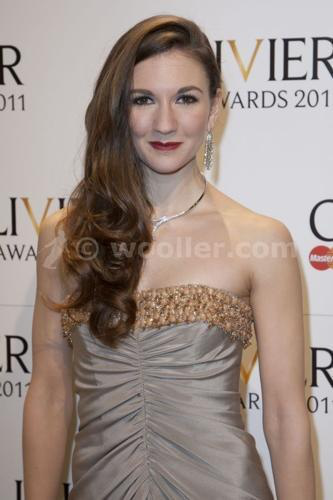

In [78]:
Image.open("/content/Part 4/Part 4/030001.jpg")

In [7]:
# ADD YOUR CODE HERE
from numpy.ma.core import resize
root = os.path.join('.', "Part 4", "Part 4")

num_samples = 2000
list_bbox = pd.read_csv(f"./list_bbox_celeba.csv")[30000:30000+num_samples] # I wrote 30000 because of the index folder Part 4
img_orig_size = (178, 218) # taken from the web page of CelebA
img_channel = 3

images = np.zeros((num_samples, img_orig_size[1], img_orig_size[0], img_channel))
y = np.zeros((num_samples, 4))
resize_transformer = transforms.Compose([
      transforms.Resize((218, 178))
])

sizes = []
for i in tqdm(range(len(list_bbox))):
    row = list_bbox.iloc[i]
    img = Image.open(f"{root}/" + row['image_id'])
    width, height = img.size
    sizes.append([width,height])
    # img = resize_transformer(img)
    img = img.resize((img_orig_size[0], img_orig_size[1]))
    img_arr = np.array(img)
    images[i] = img_arr
    # images[i] = img
    for j in range(1,5):
      if j%2 == 1:
        y[i][j-1] = int(row[j])/width*img_orig_size[0]
      else:
        y[i][j-1] = int(row[j])/height*img_orig_size[1]
print('Pre Proccess finished')

100%|██████████| 2000/2000 [00:26<00:00, 76.30it/s]

Pre Proccess finished


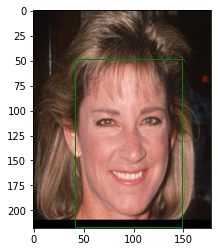

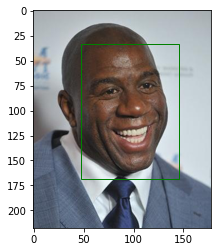

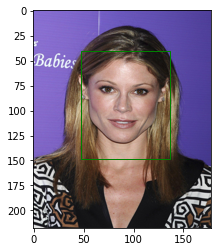

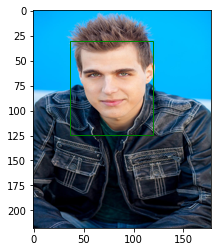

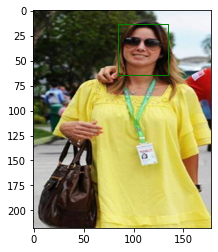

In [115]:
import matplotlib.patches as patches
import random

def show_random_images(n):

  for i in range(n):
    j = random.randint(0, num_samples)
    rect = patches.Rectangle((y[j][0], y[j][1]), y[j][2], y[j][3], linewidth=1, edgecolor='g', facecolor='none')

    fig, ax = plt.subplots()

    # Display the image
    ax.imshow(images[j]/255)

    # Add rectangle
    ax.add_patch(rect)

    plt.show()

show_random_images(5)

## 2. Models
Load the 3 chosen models for your given task. Show the model's architecture.

For the first and second pretrained models I used Facenet-Pytorch's **CASIA-Webface** and **VGGFace2**. Although they have the same architecture (Inception ResNet v1) they have different backbones 
https://github.com/timesler/facenet-pytorch
The LFW accuracy of VGGFace2 is higher than CASIA-Webface but we will test them in our dataset with our custom evaluation methods


In [9]:
!pip install facenet-pytorch

     |████████████████████████████████| 1.9 MB 5.2 MB/s 


### Question 1
Describe the main differences between the models you chose.

I have chosen 4 models. Two of them are from MTCNN (VGGFace2 and CasiaWeb

#### Load the models
Show the architectures

### First, We will test 4 models on single picture and later we will give the test data for detection, afterwards evaluating it

In [11]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


#### Now Lets detect the test imag. Later we will use the results for evaluation

##### Casia WebFace
Green square is predicted and red is the real one

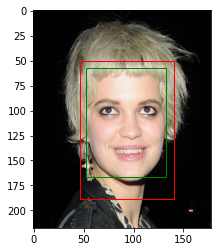

In [103]:
from PIL import Image
# ADD YOUR CODE HERE
from facenet_pytorch import MTCNN, InceptionResnetV1

mtcnn = MTCNN()

j = random.randint(0, num_samples) # Randomly select an image 


resnet = InceptionResnetV1(pretrained='casia-webface').eval().to(device)

boxes, probs = mtcnn.detect(images[j])
boxes

rect = patches.Rectangle((y[j][0], y[j][1]), y[j][2], y[j][3], linewidth=1, edgecolor='r', facecolor='none')
predicted = patches.Rectangle((boxes[0][0], boxes[0][1]), boxes[0][2] - boxes[0][0], boxes[0][3]-boxes[0][1], linewidth=1, edgecolor='g', facecolor='none')

fig, ax = plt.subplots()

# Display the image
ax.imshow(images[j]/255)

# Add rectangle
ax.add_patch(rect)
ax.add_patch(predicted)

plt.show()

In [104]:
resnet

InceptionResnetV1(
  (conv2d_1a): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2a): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2b): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (maxpool_3a): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2d_3b): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_4a): 

###### Predict on full test set

In [87]:

mtcnn = MTCNN(device=device)

resnet = InceptionResnetV1(pretrained='casia-webface').eval().to(device)

casia_webface_boxes = []
for i in tqdm(range(num_samples)):

  im = PIL_image = Image.fromarray(images[i].astype('uint8'), 'RGB')
  boxes, probs = mtcnn.detect(im)
  try:
    boxes = boxes[0]
    casia_webface_boxes.append(boxes)
  except:
    casia_webface_boxes.append([0,0,0,0])
  if i % 250 == 0:
    print(i)

  0%|          | 6/2000 [00:00<01:15, 26.51it/s]

0


 13%|█▎        | 256/2000 [00:11<01:06, 26.39it/s]

250


 25%|██▌       | 504/2000 [00:20<00:56, 26.48it/s]

500


 38%|███▊      | 755/2000 [00:31<00:50, 24.78it/s]

750


 50%|█████     | 1006/2000 [00:40<00:37, 26.62it/s]

1000


 63%|██████▎   | 1256/2000 [00:50<00:26, 27.81it/s]

1250


 75%|███████▌  | 1506/2000 [01:00<00:18, 26.27it/s]

1500


 88%|████████▊ | 1753/2000 [01:10<00:14, 16.49it/s]

1750


100%|██████████| 2000/2000 [01:22<00:00, 24.14it/s]


##### VGGFace2

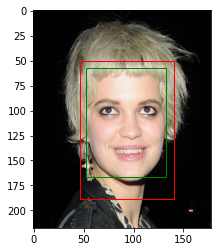

In [105]:
from PIL import Image
# j = random.randint(0, num_samples)
# j=10

resnet = InceptionResnetV1(pretrained='vggface2').eval().to(device)

boxes, probs = mtcnn.detect(images[j])

rect = patches.Rectangle((y[j][0], y[j][1]), y[j][2], y[j][3], linewidth=1, edgecolor='r', facecolor='none')
predicted = patches.Rectangle((boxes[0][0], boxes[0][1]), boxes[0][2] - boxes[0][0], boxes[0][3]-boxes[0][1], linewidth=1, edgecolor='g', facecolor='none')

fig, ax = plt.subplots()

# Display the image
ax.imshow(images[j]/255)

# Add rectangle
ax.add_patch(rect)
ax.add_patch(predicted)

plt.show()


In [106]:
resnet

InceptionResnetV1(
  (conv2d_1a): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2a): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2b): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (maxpool_3a): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2d_3b): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_4a): 

###### Predict on full test set

In [88]:
resnet = InceptionResnetV1(pretrained='vggface2').eval().to(device)
mtcnn = MTCNN(device=device)

vggface2_boxes = []
for i in tqdm(range(num_samples)):
  im = PIL_image = Image.fromarray(images[i].astype('uint8'), 'RGB')
  boxes, probs = mtcnn.detect(im)
  try:
    boxes = boxes[0]
    vggface2_boxes.append(boxes)
  except:
    vggface2_boxes.append([0,0,0,0])
  if i % 250 == 0:
    print(i)

  0%|          | 6/2000 [00:00<01:12, 27.36it/s]

0


 13%|█▎        | 256/2000 [00:12<01:05, 26.46it/s]

250


 25%|██▌       | 504/2000 [00:21<00:57, 25.81it/s]

500


 38%|███▊      | 754/2000 [00:33<00:49, 25.27it/s]

750


 50%|█████     | 1002/2000 [00:43<00:50, 19.80it/s]

1000


 63%|██████▎   | 1255/2000 [00:56<00:26, 28.44it/s]

1250


 75%|███████▌  | 1505/2000 [01:09<00:18, 26.27it/s]

1500


 88%|████████▊ | 1754/2000 [01:19<00:09, 24.83it/s]

1750


100%|██████████| 2000/2000 [01:29<00:00, 22.45it/s]


##### RetinaFace

In [107]:
!pip install git+https://github.com/elliottzheng/face-detection.git@master

  Cloning https://github.com/elliottzheng/face-detection.git (to revision master) to /tmp/pip-req-build-4z7ghh62
  Running command git clone -q https://github.com/elliottzheng/face-detection.git /tmp/pip-req-build-4z7ghh62
  Created wheel for face-detection: filename=face_detection-1.0.5-py3-none-any.whl size=1638328 sha256=8a952ce7ab0e0112bbbb8446b08a1e96d69e1e0ded7fc74aa1b0e9b3c56e2999
  Stored in directory: /tmp/pip-ephem-wheel-cache-uygcujo4/wheels/27/8f/8b/16350eed4526e15a515eda2f6ec106ad3a8646ade42452a993
Successfully built face-detection
  Attempting uninstall: face-detection
    Found existing installation: face-detection 0.2.1
    Uninstalling face-detection-0.2.1:
      Successfully uninstalled face-detection-0.2.1


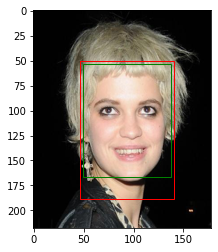

In [108]:
from PIL import Image
from face_detection import RetinaFace

# j = random.randint(0, num_samples) # Randomly select an image 

model = RetinaFace()

faces = model(images[j])

boxes, landmarks, score = faces[0]

rect = patches.Rectangle((y[j][0], y[j][1]), y[j][2], y[j][3], linewidth=1, edgecolor='r', facecolor='none')
predicted = patches.Rectangle((boxes[0], boxes[1]), boxes[2]-boxes[0], boxes[3]-boxes[1], linewidth=1, edgecolor='g', facecolor='none')

fig, ax = plt.subplots()

# Display the image
ax.imshow(images[j]/255)

# Add rectangle
ax.add_patch(rect)
ax.add_patch(predicted)

plt.show()

In [111]:
model

###### Predict on full test set

In [92]:
from skimage import io

model = RetinaFace()
retina_boxes = []

i = 0
for image in tqdm(images):
  faces = model(image)
  try:
    box, landmarks, score = faces[0]
    retina_boxes.append(box)
  except:
    retina_boxes.append([0,0,0,0])
  if i % 250 == 0:
    print(i)
  i += 1

  0%|          | 10/2000 [00:00<00:43, 45.34it/s]

0


 13%|█▎        | 253/2000 [00:10<02:01, 14.38it/s]

250


 25%|██▌       | 501/2000 [00:24<01:54, 13.07it/s]

500


 38%|███▊      | 755/2000 [00:35<00:28, 44.37it/s]

750


 50%|█████     | 1005/2000 [00:46<00:42, 23.37it/s]

1000


 63%|██████▎   | 1259/2000 [00:53<00:16, 45.62it/s]

1250


 75%|███████▌  | 1509/2000 [00:59<00:10, 45.42it/s]

1500


 88%|████████▊ | 1759/2000 [01:04<00:05, 45.86it/s]

1750


100%|██████████| 2000/2000 [01:10<00:00, 28.49it/s]


In [97]:
# We need this because from face_detection we two models and the only way we could use in one notebook to delete, pip install again and use it
# otherwise we have to restart the notebook which will cause loss of all variables
import sys
del sys.modules["face_detection"]


##### DSFD 
DSFD is our 4th model
https://github.com/hukkelas/DSFD-Pytorch-Inference

In [94]:
!pip install git+https://github.com/hukkelas/DSFD-Pytorch-Inference.git

  Cloning https://github.com/hukkelas/DSFD-Pytorch-Inference.git to /tmp/pip-req-build-81rvckva
  Running command git clone -q https://github.com/hukkelas/DSFD-Pytorch-Inference.git /tmp/pip-req-build-81rvckva
  Created wheel for face-detection: filename=face_detection-0.2.1-py3-none-any.whl size=29729 sha256=5d91eea2f87747cd99ca53f2c8c68bcaa603100f6194b617cd81023234b700c1
  Stored in directory: /tmp/pip-ephem-wheel-cache-ue4q14vi/wheels/11/5d/8c/04ffb7a0ca5427f3e674703ea75ecb16542e94efcc46d6bc1b
Successfully built face-detection
  Attempting uninstall: face-detection
    Found existing installation: face-detection 1.0.5
    Uninstalling face-detection-1.0.5:
      Successfully uninstalled face-detection-1.0.5


['DSFDDetector', 'RetinaNetResNet50', 'RetinaNetMobileNetV1']


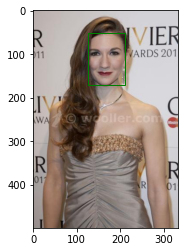

In [85]:
import cv2
import face_detection
import matplotlib.image as mpimg

print(face_detection.available_detectors)
detector = face_detection.build_detector(
  "DSFDDetector", confidence_threshold=.5, nms_iou_threshold=.3)
# BGR to RGB
im = cv2.imread(str("/content/Part 4/Part 4/0"+str(int(30000+j))+".jpg") )[:, :, ::-1]
img = mpimg.imread(str("/content/Part 4/Part 4/0"+str(int(30000+j))+".jpg"))


detections = detector.detect(im)


# rect = patches.Rectangle((y[j][0], y[j][1]), y[j][2], y[j][3], linewidth=1, edgecolor='r', facecolor='none')
predicted = patches.Rectangle((detections[0][0], detections[0][1]), detections[0][2]-detections[0][0], detections[0][3]-detections[0][1], linewidth=1, edgecolor='g', facecolor='none')

fig, ax = plt.subplots()

# Display the image
ax.imshow(img)

# Add rectangle
# ax.add_patch(rect)
ax.add_patch(predicted)

plt.show()

The part below takes up to two with 2000 examples on GPU

Change num_samples variable size for shorter runtime

###### Predict on full test set

In [23]:
import cv2
import face_detection
from tqdm import tqdm

num_samples = 2000

print(face_detection.available_detectors)
detector = face_detection.build_detector(
  "DSFDDetector", confidence_threshold=.5, nms_iou_threshold=.3)

boxes_dsfdd = []
for i in tqdm(range(num_samples)):
  # print(i)
  row = list_bbox.iloc[i]

  img = cv2.imread(f"/content/Part 4/Part 4/" + row['image_id'])[:, :, ::-1]
  faces = detector.detect(img)
  try:
    a = faces[0][0]/sizes[i][0]*img_orig_size[0]
    b = faces[0][1]/sizes[i][1]*img_orig_size[1]
    c = faces[0][2]/sizes[i][0]*img_orig_size[0]
    d = faces[0][3]/sizes[i][1]*img_orig_size[1]
    boxes_dsfdd.append([a,b,c,d])
  except:
    boxes_dsfdd.append([0,0,0,0])

['DSFDDetector', 'RetinaNetResNet50', 'RetinaNetMobileNetV1']


100%|██████████| 2000/2000 [1:39:05<00:00,  2.97s/it]


## 3. Evaluation
This is the most important part. Please give a detailed comparison between the models.

**Implement your metrics manually**. Do not use pre defined Pytorch metrics.

Calculate the metrics for each model on the test set.

Plot the metrics.

Show some predictions in comparison to the ground truth.

#### Evaluate your models

#### Define the metrics

##### Intersection Over Union

In [24]:
def IOU(boxA, boxB):

  x1, y1, w1, h1 = boxA
  x2, y2, w2, h2 = boxB

  width_int = min(x1 + w1, x2 + w2) - max(x1, x2)
  height_int = min(y1 + h1, y2 + h2) - max(y1, y2)

  if width_int <= 0 or height_int <= 0: 
    return 0

  I = width_int * height_int
  U = w1 * h1 + w2 * h2 - I 

  return I / U

Precision

In [25]:
def precision(y, y_pred):
    precs = []
    for i in range(len(y_pred)):
        x1, y1, w1, h1 = y[i]
        x2, y2, w2, h2 = y_pred[i]

        width_int = min(x1 + w1, x2 + w2) - max(x1, x2)
        height_int = min(y1 + h1, y2 + h2) - max(y1, y2)

        if width_int <= 0 or height_int <= 0: 
          precs.append( true_percentage )
          continue

        I = width_int * height_int # Intersection
        A = w1*h1 # Area of the real box
        true_percentage = I/A if I/A<1 else 1
        precs.append( true_percentage )
    return np.mean(precs)

Recall

In [26]:
def recall(y, y_pred):
    true_region = []
    for i in range(len(y_pred)):
        x1, y1, w1, h1 = y[i]
        x2, y2, w2, h2 = y_pred[i]

        width_int = min(x1 + w1, x2 + w2) - max(x1, x2)
        height_int = min(y1 + h1, y2 + h2) - max(y1, y2)

        if width_int <= 0 or height_int <= 0: 
          true_region.append( true_percentage )
          continue

        I = width_int * height_int # Intersection
        A = w2*h2 # Area of the predicted box
        true_percentage = I/A if I/A<1 else 1
        true_region.append( true_percentage )
    return np.mean(true_region)

F1 Score combination of precision and recall

In [33]:
def f1_score(y, y_pred):
  prec = precision(y, y_pred)
  rec = recall(y, y_pred)
  return 2*prec*rec/(prec+rec)

#### Show the metrics results

VGGFace 2 Results

In [98]:
print('Precision', precision(y,vggface2_boxes))
print('Recall', recall(y,vggface2_boxes))
print('F1 score', f1_score(y,vggface2_boxes))
print('IOU', np.mean( [IOU(y[i], vggface2_boxes[i]) for i in range(len(vggface2_boxes))] ))

Precision 0.8306242900129792
Recall 0.467128881353912
F1 score 0.5979697896025491
IOU 0.4122673669736884


CasiaWebFace results

In [99]:
print('Precision', precision(y,casia_webface_boxes))
print('Recall', recall(y,casia_webface_boxes))
print('F1 score', f1_score(y,casia_webface_boxes))
print('IOU', np.mean( [IOU(y[i], casia_webface_boxes[i]) for i in range(len(casia_webface_boxes))] ))

Precision 0.8306242900129792
Recall 0.467128881353912
F1 score 0.5979697896025491
IOU 0.4122673669736884


Retina Results

In [100]:
print('Precision', precision(y,retina_boxes))
print('Recall', recall(y,retina_boxes))
print('F1 score', f1_score(y,retina_boxes))
print('IOU', np.mean( [IOU(y[i], retina_boxes[i]) for i in range(len(retina_boxes))] ))

Precision 0.8500500947093235
Recall 0.46994908947578184
F1 score 0.6052735074439698
IOU 0.42324500804645565


DSFDD

In [101]:
print('Precision', precision(y,boxes_dsfdd))
print('Recall', recall(y,boxes_dsfdd))
print('F1 score', f1_score(y,boxes_dsfdd))
print('IOU', np.mean( [IOU(y[i], boxes_dsfdd[i]) for i in range(len(boxes_dsfdd))] ))

Precision 0.851512593501703
Recall 0.4704671928818997
F1 score 0.6060739259323086
IOU 0.42703262461251884


#### Show some predictions

In [102]:
# ADD YOUR CODE HERE

# I showed them above with every model

## 4. Conclusion
First loaded the data from kaggle( the real one not the one with wrong annotations). Since Data is big we used only one part and I defined <b>num_samples</b> variable that helps us control the size of the test test. Each part of the data consists of 10 000  samples and the deafult for us was 2000 ( It is low because of the long runtime of some models).
After preprocessing and displaying the images we loaded the models.
First we predicted only one image and then the whole testset. After creating boxes variables we checked them with 4 metrics ( IOU, Precision, Recall and F1 Score). 
All the models I have used had one common problem they returned bigger area than the real box which was leading higher precision but lower recall.
One more thing to add is that the real boxes which are given are sometimes not accurate too. It is really hard to define what really is face is and where it ends. Maybe some 3D approaches will give us more detailed results about face. But thats a work another day

### Answer the questions
#### Question 2. 
Which model performed the best? Why do you think it performed better than others?

<b>Answer</b>: According to metrics from all the models DSFD(Dual Shot Face Detector) performed better than other three models. Casia and VGGFace gave the same results even though they have trained on different datas it appears they are not different. Retina face good as well slight less accurate than DSFD 

#### Question 3. 
How could you improve the performance of the models?

<b>Answer</b>: Fine tuning and training the models probably will give us more accurate results. 